# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Set the style for our plots
plt.style.use('fivethirtyeight')
sns.set_palette('bright')
plt.rcParams['figure.figsize'] = (12, 8)

In [13]:
# 1. Load the dataset
print("Loading the dataset...")
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
print("Dataset loaded successfully!")

Loading the dataset...
Dataset loaded successfully!


In [14]:
# 2. Data Exploration
print("\n===== DATASET EXPLORATION =====")
df.head()


===== DATASET EXPLORATION =====


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [15]:
print("\nDataset shape:")
print(df.shape)


Dataset shape:
(50000, 14)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [17]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [18]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [19]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [20]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [21]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


In [22]:
# Check the target variable distribution (booking_complete)
print("\nTarget variable distribution:")
booking_completion_pct = df['booking_complete'].value_counts(normalize=True) * 100
print(booking_completion_pct)
print(f"Only {booking_completion_pct[1]:.2f}% of bookings are completed.")


Target variable distribution:
booking_complete
0    85.044
1    14.956
Name: proportion, dtype: float64
Only 14.96% of bookings are completed.


In [23]:
# Check unique values for categorical variables
print("\nUnique values in categorical columns:")
for col in ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())
    print()


Unique values in categorical columns:
sales_channel: 2 unique values
sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

trip_type: 3 unique values
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

flight_day: 7 unique values
flight_day
1    8102
3    7674
2    7673
4    7424
5    6761
Name: count, dtype: int64

route: 799 unique values
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
Name: count, dtype: int64

booking_origin: 104 unique values
booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Name: count, dtype: int64



In [24]:
# 3. Visualize key aspects of the data
print("\n===== DATA VISUALIZATION =====")



===== DATA VISUALIZATION =====


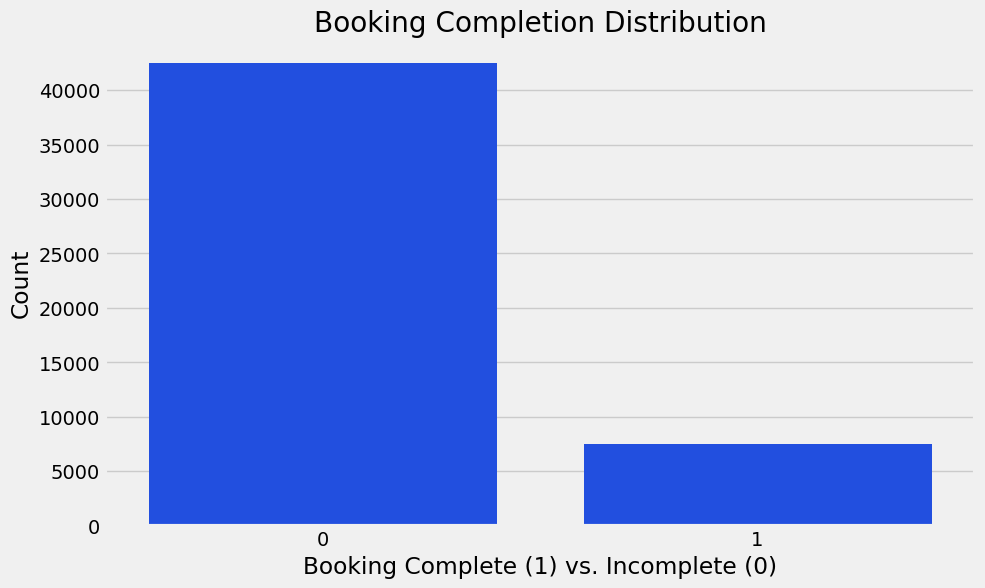

In [25]:
# Plot booking completion distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='booking_complete', data=df)
plt.title('Booking Completion Distribution')
plt.ylabel('Count')
plt.xlabel('Booking Complete (1) vs. Incomplete (0)')
plt.show()

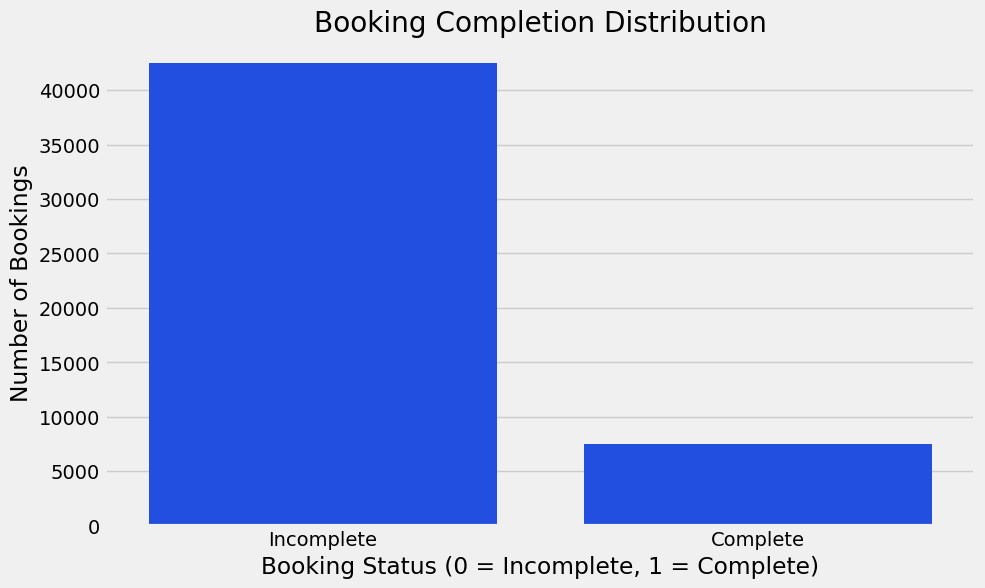

In [26]:
# Booking completion distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='booking_complete', data=df)
plt.title('Booking Completion Distribution')
plt.ylabel('Number of Bookings')
plt.xlabel('Booking Status (0 = Incomplete, 1 = Complete)')
plt.xticks([0, 1], ['Incomplete', 'Complete'])
plt.show()

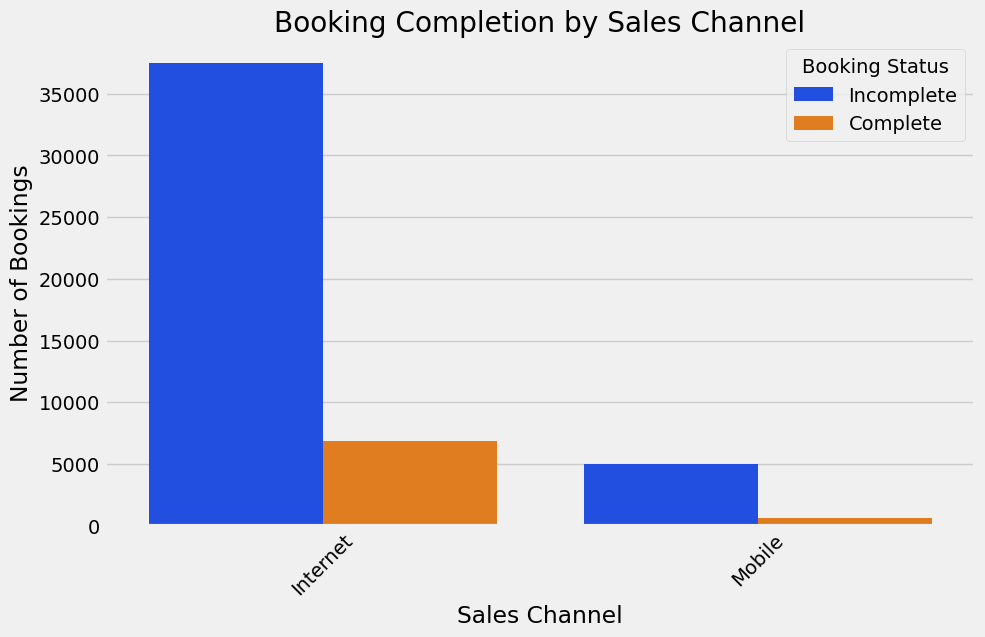

In [27]:
# Booking completion by sales channel
plt.figure(figsize=(10, 6))
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.title('Booking Completion by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Status', labels=['Incomplete', 'Complete'])
plt.xticks(rotation=45)
plt.show()

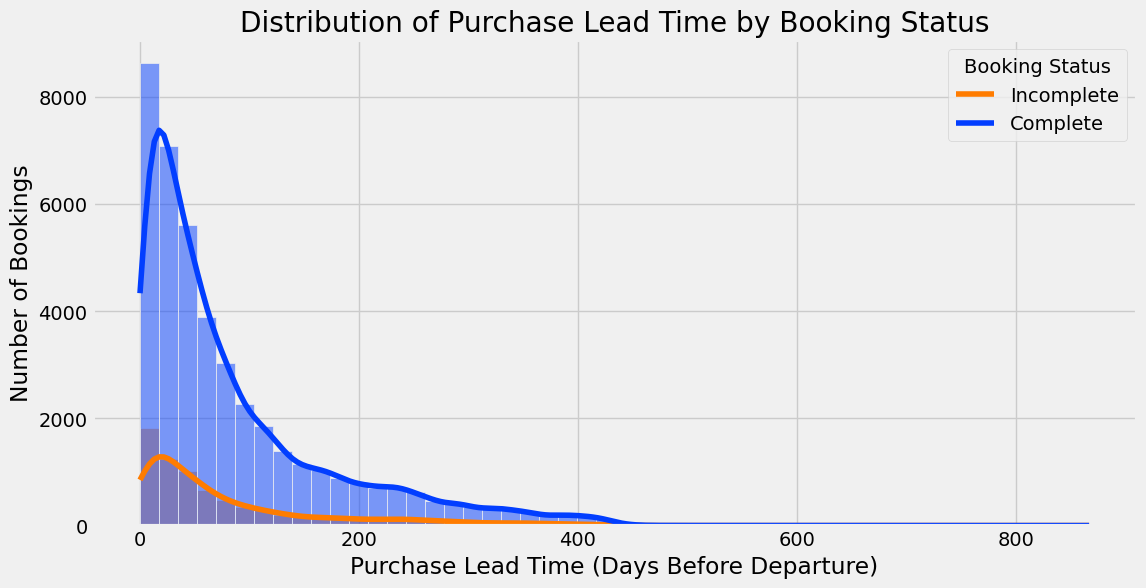

In [28]:
# Purchase lead time
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='purchase_lead', hue='booking_complete', bins=50, kde=True)
plt.title('Distribution of Purchase Lead Time by Booking Status')
plt.xlabel('Purchase Lead Time (Days Before Departure)')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Status', labels=['Incomplete', 'Complete'])
plt.show()

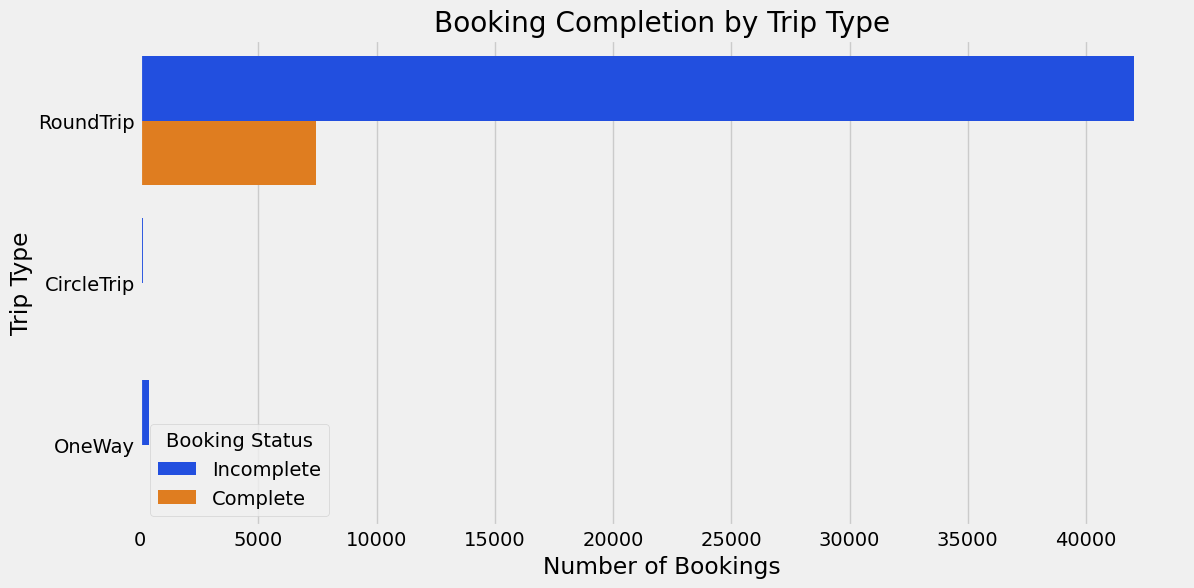

In [29]:
# Trip type vs booking
plt.figure(figsize=(12, 6))
sns.countplot(y='trip_type', hue='booking_complete', data=df)
plt.title('Booking Completion by Trip Type')
plt.xlabel('Number of Bookings')
plt.ylabel('Trip Type')
plt.legend(title='Booking Status', labels=['Incomplete', 'Complete'])
plt.show()

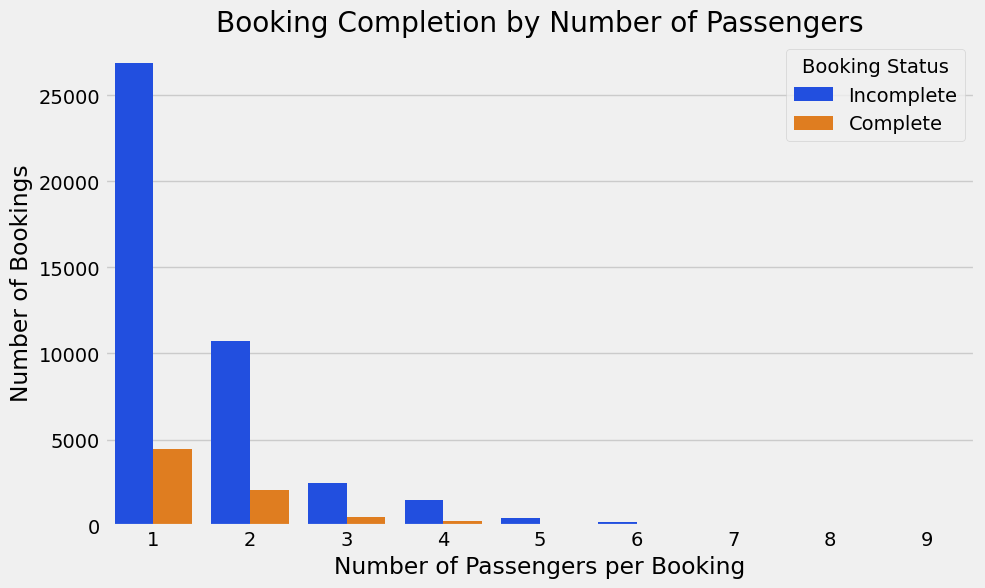

In [30]:
# Number of passengers vs booking
plt.figure(figsize=(10, 6))
sns.countplot(x='num_passengers', hue='booking_complete', data=df)
plt.title('Booking Completion by Number of Passengers')
plt.xlabel('Number of Passengers per Booking')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Status', labels=['Incomplete', 'Complete'])
plt.show()

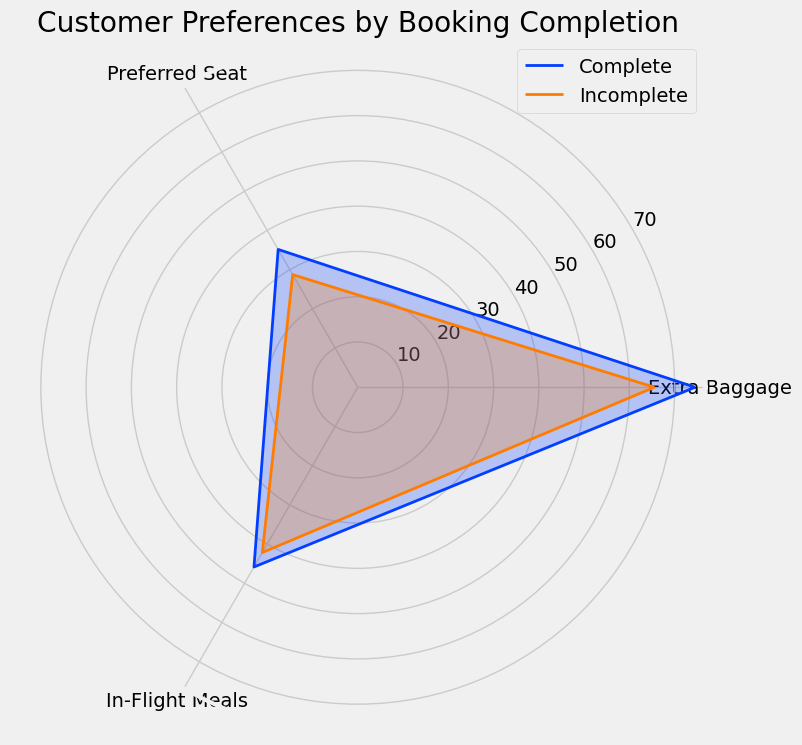

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate data
labels = ['Extra Baggage', 'Preferred Seat', 'In-Flight Meals']
extras = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Calculate percentage of users who wanted each extra per booking status
complete_means = [df[df['booking_complete'] == 1][extra].mean() * 100 for extra in extras]
incomplete_means = [df[df['booking_complete'] == 0][extra].mean() * 100 for extra in extras]

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
complete_means += complete_means[:1]
incomplete_means += incomplete_means[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, complete_means, label='Complete', linewidth=2)
ax.fill(angles, complete_means, alpha=0.25)

ax.plot(angles, incomplete_means, label='Incomplete', linewidth=2)
ax.fill(angles, incomplete_means, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('Customer Preferences by Booking Completion')
ax.set_rlabel_position(30)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


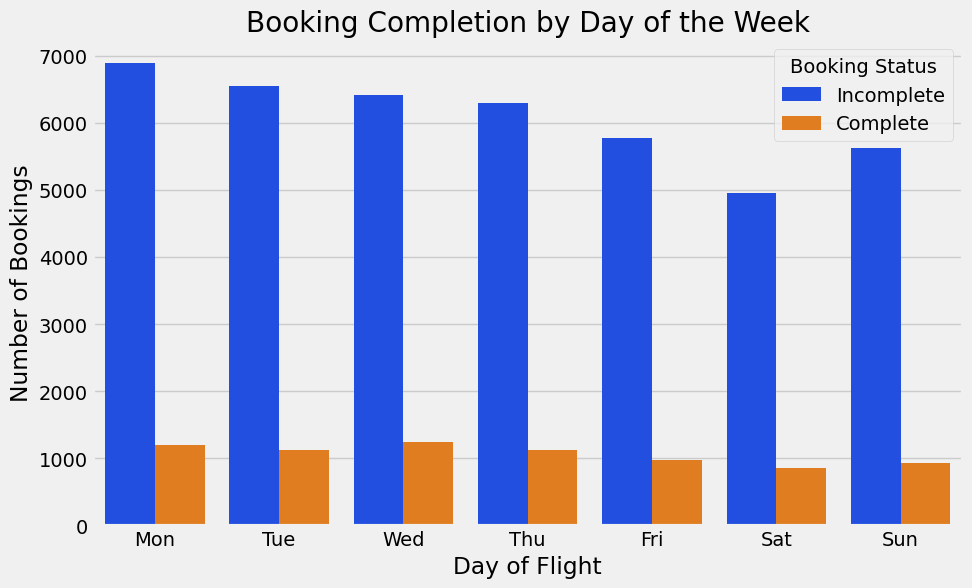

In [32]:
# Flight day vs booking
plt.figure(figsize=(10, 6))
day_names = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
df['flight_day_name'] = df['flight_day'].map(day_names)
sns.countplot(x='flight_day_name', hue='booking_complete', data=df,
              order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Booking Completion by Day of the Week')
plt.xlabel('Day of Flight')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Status', labels=['Incomplete', 'Complete'])
plt.show()

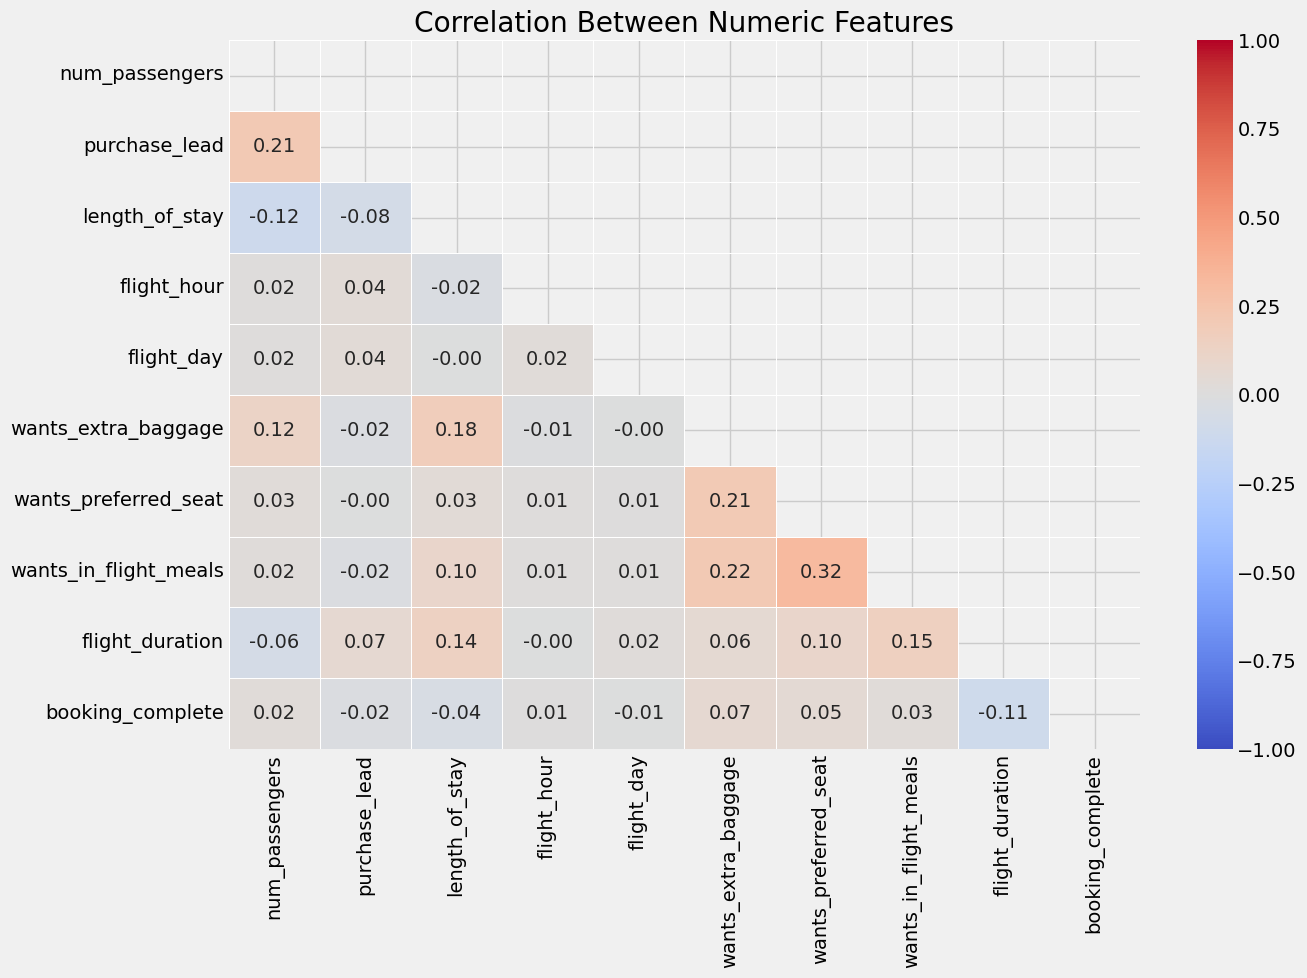

In [33]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()

In [34]:
# 4. Feature Engineering
print("\n===== FEATURE ENGINEERING =====")


===== FEATURE ENGINEERING =====


In [35]:
# Create a copy of the dataset for feature engineering
df_processed = df.copy()


In [36]:
print("\nCreating enhanced features...")

# Base features from user
df_processed['total_add_ons'] = (
    df_processed['wants_extra_baggage'] +
    df_processed['wants_preferred_seat'] +
    df_processed['wants_in_flight_meals']
)

df_processed['is_weekend'] = df_processed['flight_day'].apply(lambda x: 1 if x in [6, 7] else 0)

df_processed['time_of_day'] = pd.cut(
    df_processed['flight_hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Early Morning', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)

df_processed['lead_time_category'] = pd.cut(
    df_processed['purchase_lead'],
    bins=[0, 7, 30, 90, np.inf],
    labels=['Last Minute', 'Short Notice', 'Advanced', 'Very Advanced'],
    include_lowest=True
)

df_processed['stay_duration_category'] = pd.cut(
    df_processed['length_of_stay'],
    bins=[0, 3, 7, 14, 30, np.inf],
    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'],
    include_lowest=True
)

df_processed['origin'] = df_processed['route'].str[:3]
df_processed['destination'] = df_processed['route'].str[3:]

# Enhanced domestic check (if no origin country info, fallback to AKL logic)
df_processed['is_domestic'] = ((df_processed['origin'] == 'AKL') &
                               (df_processed['booking_origin'] == 'New Zealand')).astype(int)

df_processed['booking_from_origin'] = ((df_processed['booking_origin'] == 'New Zealand') &
                                       (df_processed['origin'] == 'AKL')).astype(int)

# --- Advanced Features ---
# 1. Add-on interaction with lead time
df_processed['addons_by_lead'] = df_processed['total_add_ons'] * df_processed['purchase_lead']


# 2. Route popularity (how frequently a route appears)
route_freq = df_processed['route'].value_counts().to_dict()
df_processed['route_popularity'] = df_processed['route'].map(route_freq)

# 3. Rush booking (purchase lead < 3 days)
df_processed['is_rush_booking'] = (df_processed['purchase_lead'] < 3).astype(int)

# 4. Cyclical transformation of flight hour
df_processed['flight_hour_sin'] = np.sin(2 * np.pi * df_processed['flight_hour'] / 24)
df_processed['flight_hour_cos'] = np.cos(2 * np.pi * df_processed['flight_hour'] / 24)



Creating enhanced features...


In [37]:
# Final overview
print("\nNew dataset shape after feature engineering:", df_processed.shape)
print("\nFeature preview:")
preview_cols = ['total_add_ons', 'is_weekend', 'time_of_day', 'lead_time_category',
                'stay_duration_category', 'origin', 'destination', 'is_domestic',
                'booking_from_origin', 'addons_by_lead',
                'route_popularity', 'is_rush_booking', 'flight_hour_sin', 'flight_hour_cos']
print(df_processed[preview_cols].head())


New dataset shape after feature engineering: (50000, 29)

Feature preview:
   total_add_ons  is_weekend    time_of_day lead_time_category  \
0              1           1        Morning      Very Advanced   
1              0           1  Early Morning      Very Advanced   
2              2           0      Afternoon      Very Advanced   
3              1           1  Early Morning      Very Advanced   
4              2           0      Afternoon           Advanced   

  stay_duration_category origin destination  is_domestic  booking_from_origin  \
0                   Long    AKL         DEL            1                    1   
1                   Long    AKL         DEL            1                    1   
2                   Long    AKL         DEL            0                    0   
3              Very Long    AKL         DEL            1                    1   
4                   Long    AKL         DEL            0                    0   

   addons_by_lead  route_popularity  is_

In [38]:
# 5. Prepare Data for Modeling
print("\n===== PREPARING DATA FOR MODELING =====")

# Define features and target
X = df_processed.drop('booking_complete', axis=1)
y = df_processed['booking_complete']

# Drop unnecessary columns
columns_to_drop = ['route', 'origin', 'destination', 'flight_day_name',
                   'time_of_day', 'lead_time_category', 'stay_duration_category']
X = X.drop(columns_to_drop, axis=1, errors='ignore')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Booking completion rate in training set: {y_train.mean()*100:.2f}%")
print(f"Booking completion rate in test set: {y_test.mean()*100:.2f}%")


===== PREPARING DATA FOR MODELING =====
Training set size: (37500, 21)
Test set size: (12500, 21)
Booking completion rate in training set: 14.96%
Booking completion rate in test set: 14.95%


In [39]:
# Assuming df_processed is your final dataframe after all preprocessing
# Define features and target
X = df_processed.drop('booking_complete', axis=1)
y = df_processed['booking_complete']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



In [40]:
# 1. Build preprocessing pipeline
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [41]:
# 2. Build the LightGBM Model Pipeline
# LightGBM Classifier with preprocessing steps
import lightgbm as lgb
from scipy.stats import uniform, randint
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(objective='binary',
                                      metric='binary_error',
                                      scale_pos_weight=1.0,  # Adjust this if necessary
                                      learning_rate=0.05,
                                      max_depth=8,
                                      num_leaves=31,
                                      random_state=42))
])

In [42]:

# 3. Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'classifier__learning_rate': uniform(0.01, 0.1),  # Uniform distribution from 0.01 to 0.1
    'classifier__num_leaves': randint(20, 200),        # Random integer between 20 and 200
    'classifier__max_depth': randint(5, 20),            # Random integer between 5 and 20
    'classifier__scale_pos_weight': uniform(1.0, 3.0),  # Uniform distribution from 1.0 to 3.0
    'classifier__n_estimators': randint(50, 300)        # Random integer between 50 and 300
}


In [43]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model,
                                   param_distributions=param_dist,
                                   n_iter=50,  # Number of random combinations to try
                                   cv=5,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 5609, number of negative: 31891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 528
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149573 -> initscore=-1.737951
[LightGBM] [Info] Start training from score -1.737951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['num_passengers',
                                                                                'purchase_lead',
                                                                                'length_of_stay',
                                                                                'flight_hour',
                                                                                'flight_day',
                                                                                'wants_extra_baggage',
                                                                                'wants_preferred_seat',
                                                                                'wants_in_flight_meals',
                                                                                'flight_duration',
                                                                                'total_add_ons',
                                                                                'is_weekend',
                                                                                'is_domestic',
                                                                                'booking_from_origin...
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d769f7c7750>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d769cf30450>,
                                        'classifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d769f7c6950>,
                                        'classifier__scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d769cf32d90>},
                   random_state=42, verbose=2)

In [44]:
# 4. Retraining with best parameters
best_lgb_model = random_search.best_estimator_


In [45]:
# 5. Model Evaluation on Test Set
y_pred = best_lgb_model.predict(X_test)
y_pred_proba = best_lgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# 6. Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print individual evaluation metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10631
           1       0.55      0.07      0.12      1869

    accuracy                           0.85     12500
   macro avg       0.71      0.53      0.52     12500
weighted avg       0.81      0.85      0.80     12500


Accuracy: 0.8525
Precision: 0.5546
Recall: 0.0680
F1 Score: 0.1211
ROC AUC: 0.7979


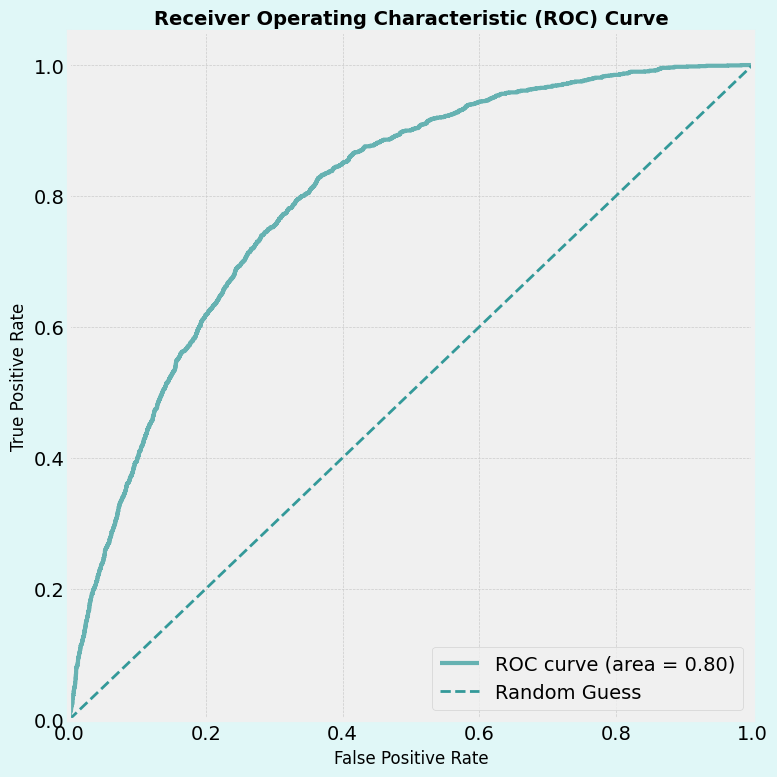

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

# Light teal color palette
teal_main = '#66b2b2'      # Main teal
teal_background = '#e0f7f7'  # Very light teal background
teal_line = '#339999'      # Darker teal for contrast

# Plot ROC Curve
plt.figure(figsize=(8, 8), facecolor=teal_background)
plt.plot(fpr, tpr, color=teal_main, lw=3, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color=teal_line, lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, weight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save in high quality for PPT
plt.savefig("roc_curve_teal.png", dpi=300, facecolor=teal_background)
plt.show()


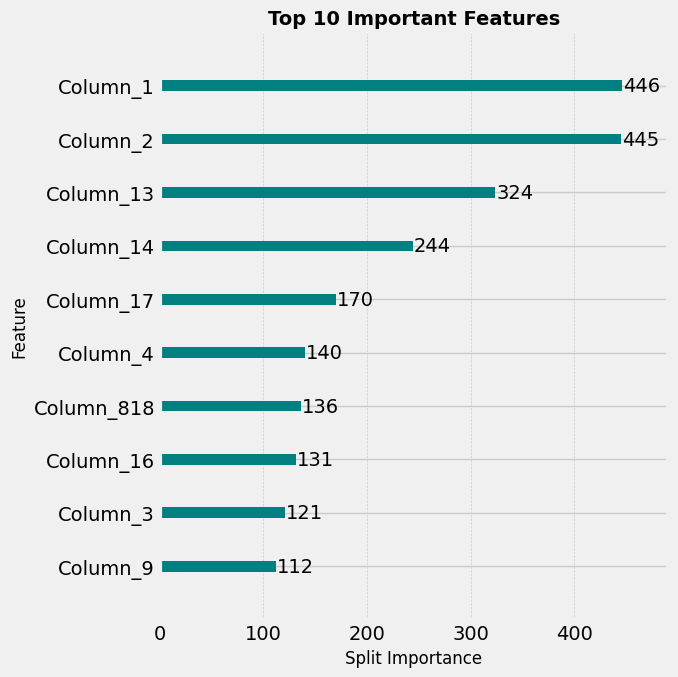

In [61]:
import lightgbm as lgb

# Plot feature importance as a bar chart
ax = lgb.plot_importance(best_lgb_model.named_steps['classifier'],
                         max_num_features=10,
                         importance_type='split',
                         figsize=(7, 7),
                         color='#008080')  # Teal

plt.title('Top 10 Important Features', fontsize=14, weight='bold')
plt.xlabel('Split Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot
plt.savefig("feature_importance_bar_teal.png", dpi=300)
plt.show()


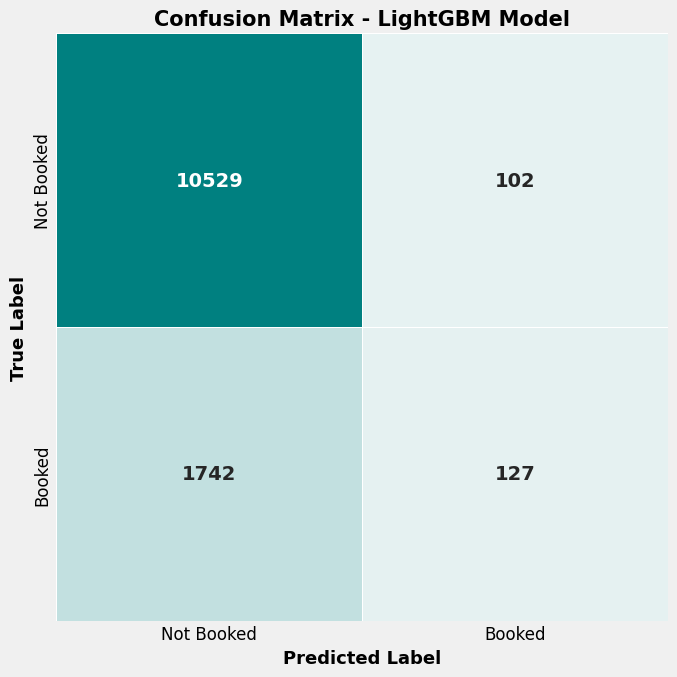

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Booked', 'Booked']

# Create a smooth teal gradient with many steps
teal_cmap = sns.light_palette("teal", as_cmap=True)

# Plot heatmap using the full value range
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=teal_cmap, linewidths=0.5, linecolor='white',
            xticklabels=labels, yticklabels=labels, cbar=False,
            vmin=0, vmax=cm.max(), annot_kws={"size": 14, "weight": "bold"})

plt.xlabel('Predicted Label', fontsize=13, weight='bold')
plt.ylabel('True Label', fontsize=13, weight='bold')
plt.title('Confusion Matrix - LightGBM Model', fontsize=15, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("confusion_matrix_teal_gradient.png", dpi=300)
plt.show()


In [49]:
# # 6. Build preprocessing pipeline
# print("\n===== BUILDING PREPROCESSING PIPELINE =====")

# # Identify numerical and categorical features
# numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# print(f"Numerical features: {numerical_features}")
# print(f"Categorical features: {categorical_features}")

# # Create preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])


In [50]:
# # 7. Build and train multiple models
# print("\n===== BUILDING AND TRAINING MULTIPLE MODELS =====")

# # Import additional models with error handling
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier

# # Try importing optional packages
# models_available = {'LogisticRegression': True, 'RandomForest': True, 'GradientBoosting': True}

# # Try importing XGBoost
# try:
#     import xgboost as xgb
#     models_available['XGBoost'] = True
#     print("XGBoost is available.")
# except ImportError:
#     models_available['XGBoost'] = False
#     print("XGBoost is not installed. Skipping XGBoost model.")

# # Try importing LightGBM
# try:
#     import lightgbm as lgb
#     models_available['LightGBM'] = True
#     print("LightGBM is available.")
# except ImportError:
#     models_available['LightGBM'] = False
#     print("LightGBM is not installed. Skipping LightGBM model.")

# # Try importing CatBoost
# try:
#     import catboost as cb
#     models_available['CatBoost'] = True
#     print("CatBoost is available.")
# except ImportError:
#     models_available['CatBoost'] = False
#     print("CatBoost is not installed. Skipping CatBoost model.")

# # Create a function to evaluate models
# def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
#     # Train the model
#     model.fit(X_train, y_train)

#     # Make predictions
#     y_pred = model.predict(X_test)
#     y_pred_proba = model.predict_proba(X_test)[:, 1]

#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred_proba)

#     return {
#         'Model': model_name,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'ROC AUC': roc_auc,
#         'Trained Model': model
#     }

# # Define pipelines for different models
# models = {
#     'Logistic Regression': Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', LogisticRegression(max_iter=1000, random_state=42))
#     ]),
#     'Random Forest': Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
#     ]),
#     'Gradient Boosting': Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', GradientBoostingClassifier(n_estimators=200, random_state=42))
#     ])
# }

# # Add models that might not be available
# if models_available['XGBoost']:
#     models['XGBoost'] = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', xgb.XGBClassifier(n_estimators=200, random_state=42))
#     ])

# if models_available['LightGBM']:
#     models['LightGBM'] = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', lgb.LGBMClassifier(n_estimators=200, random_state=42))
#     ])

# if models_available['CatBoost']:
#     models['CatBoost'] = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', cb.CatBoostClassifier(n_estimators=200, random_state=42, verbose=0))
#     ])

# # Evaluate all models
# results = []
# print("\nTraining and evaluating multiple models...")
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
#     results.append(result)

# # Create results DataFrame and sort by ROC AUC
# results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
# print("\nModel comparison:")
# print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']])

# # Plot model comparison
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Model', y='ROC AUC', data=results_df)
# plt.title('Model Comparison by ROC AUC Score')
# plt.ylim(0.5, 1.0)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Select the best model
# best_model_info = results_df.iloc[0]
# best_model = best_model_info['Trained Model']
# best_model_name = best_model_info['Model']
# print(f"\nBest model: {best_model_name} with ROC AUC of {best_model_info['ROC AUC']:.4f}")

# # Create and train a Voting Classifier with the top models if we have at least 2 models
# if len(models) >= 2:
#     print("\nCreating an Ensemble with Voting Classifier...")
#     # Take up to top 3 models, but at least 2
#     num_models = min(3, len(models))
#     top_models = results_df.head(num_models)['Model'].tolist()
#     print(f"Selected models for voting: {top_models}")

#     estimators = [(name, models[name]) for name in top_models]
#     voting_clf = VotingClassifier(estimators=estimators, voting='soft')
#     voting_result = evaluate_model(voting_clf, X_train, X_test, y_train, y_test, 'Voting Ensemble')

#     # Create and train a Stacking Classifier
#     print("\nCreating a Stacking Classifier...")
#     stacking_estimators = [(name, models[name].named_steps['classifier']) for name in top_models]
#     stacking_clf = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', StackingClassifier(
#             estimators=stacking_estimators,
#             final_estimator=LogisticRegression(),
#             cv=5,
#             stack_method='predict_proba'
#         ))
#     ])
#     stacking_result = evaluate_model(stacking_clf, X_train, X_test, y_train, y_test, 'Stacking Ensemble')

#     # Update results with ensemble models
#     results.append(voting_result)
#     results.append(stacking_result)
#     results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
#     print("\nUpdated model comparison with ensembles:")
#     print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']])

#     # Final selection of the best model
#     best_model_info = results_df.iloc[0]
#     best_model = best_model_info['Trained Model']
#     best_model_name = best_model_info['Model']
#     print(f"\nFinal best model: {best_model_name} with ROC AUC of {best_model_info['ROC AUC']:.4f}")
# else:
#     print("\nNot enough models to create ensemble methods. Using best individual model.")


In [51]:
# # 8. Evaluate the best model in detail
# print("\n===== DETAILED EVALUATION OF BEST MODEL =====")

# # Make predictions
# y_pred = best_model.predict(X_test)
# y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# # Calculate metrics
# print(f"\nDetailed evaluation for {best_model_name}:")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title(f'Confusion Matrix - {best_model_name}')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

# # Plot ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 8))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'ROC Curve - {best_model_name}')
# plt.legend(loc="lower right")
# plt.grid(True, alpha=0.3)
# plt.show()

# # Calculate and print key metrics
# metrics = {
#     "ROC AUC Score": roc_auc_score(y_test, y_pred_proba),
#     "Accuracy": accuracy_score(y_test, y_pred),
#     "Precision": precision_score(y_test, y_pred),
#     "Recall": recall_score(y_test, y_pred),
#     "F1 Score": f1_score(y_test, y_pred)
# }

# for metric_name, metric_value in metrics.items():
#     print(f"{metric_name}: {metric_value:.4f}")

# # Plot precision-recall curve
# from sklearn.metrics import precision_recall_curve, average_precision_score

# precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# avg_precision = average_precision_score(y_test, y_pred_proba)

# plt.figure(figsize=(10, 8))
# plt.plot(recall, precision, color='blue', lw=2,
#          label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
# plt.axhline(y=y_test.mean(), color='red', linestyle='--',
#             label=f'No Skill (AP = {y_test.mean():.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title(f'Precision-Recall Curve - {best_model_name}')
# plt.legend(loc="best")
# plt.grid(True, alpha=0.3)
# plt.show()

# print(f"Average Precision Score: {avg_precision:.4f}")

# # Analyze prediction threshold effects
# thresholds = np.arange(0.1, 1.0, 0.1)
# threshold_metrics = []

# for threshold in thresholds:
#     y_pred_t = (y_pred_proba >= threshold).astype(int)

#     threshold_metrics.append({
#         'Threshold': threshold,
#         'Accuracy': accuracy_score(y_test, y_pred_t),
#         'Precision': precision_score(y_test, y_pred_t, zero_division=0),
#         'Recall': recall_score(y_test, y_pred_t, zero_division=0),
#         'F1': f1_score(y_test, y_pred_t, zero_division=0),
#         'Positives': sum(y_pred_t == 1)
#     })

# threshold_df = pd.DataFrame(threshold_metrics)

# # Plot threshold effects
# plt.figure(figsize=(14, 8))
# plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'b-', label='Accuracy')
# plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'g-', label='Precision')
# plt.plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-', label='Recall')
# plt.plot(threshold_df['Threshold'], threshold_df['F1'], 'y-', label='F1 Score')
# plt.title('Effect of Prediction Threshold on Metrics')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()

# # Plot volume of flagged bookings at different thresholds
# plt.figure(figsize=(12, 6))
# plt.bar(threshold_df['Threshold'], threshold_df['Positives'], color='purple', alpha=0.7)
# plt.title('Number of Predicted Positive Bookings at Different Thresholds')
# plt.xlabel('Threshold')
# plt.ylabel('Number of Bookings Predicted to Complete')
# plt.grid(True, alpha=0)

In [ ]:
# 9. Cross-validation evaluation
print("\n===== CROSS-VALIDATION EVALUATION =====")

In [ ]:
# # Perform cross-validation
# cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
# print(f"Cross-validation ROC AUC scores: {cv_scores}")
# print(f"Mean ROC AUC: {cv_scores.mean():.4f}")
# print(f"Standard deviation: {cv_scores.std():.4f}")

In [ ]:
# 10. Feature Importance Analysis
print("\n===== FEATURE IMPORTANCE ANALYSIS =====")

In [ ]:
# # Function to extract feature importances based on model type
# def get_feature_importances(model, preprocessor):
#     """Extract feature importances from various model types"""
#     feature_names = []
#     for name, transformer, features in preprocessor.transformers_:
#         if name == 'num':
#             feature_names.extend(features)
#         elif name == 'cat':
#             for i, category in enumerate(features):
#                 if hasattr(transformer, 'categories_'):
#                     cats = transformer.categories_[i]
#                     for cat in cats:
#                         feature_names.append(f"{category}_{cat}")
#                 else:
#                     feature_names.append(category)

#     # Get the actual classifier from the pipeline
#     if hasattr(model, 'named_steps'):
#         classifier = model.named_steps['classifier']
#     else:
#         classifier = model

#     # Extract importances based on model type
#     if hasattr(classifier, 'feature_importances_'):
#         # Tree-based models
#         importances = classifier.feature_importances_
#     elif hasattr(classifier, 'coef_'):
#         # Linear models
#         importances = np.abs(classifier.coef_[0])
#     elif hasattr(classifier, 'estimators_') and not isinstance(classifier, (VotingClassifier, StackingClassifier)):
#         # Average importances from all base estimators
#         all_importances = []
#         for estimator in classifier.estimators_:
#             if hasattr(estimator, 'feature_importances_'):
#                 all_importances.append(estimator.feature_importances_)
#         if all_importances:
#             importances = np.mean(all_importances, axis=0)
#         else:
#             return None, None
#     else:
#         # For ensemble models, use permutation importance
#         from sklearn.inspection import permutation_importance
#         if isinstance(model, Pipeline):
#             result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
#             importances = result.importances_mean
#             return list(X_test.columns), importances
#         else:
#             return None, None

#     return feature_names[:len(importances)], importances

# # Extract importance information
# try:
#     if best_model_name in ['Voting Ensemble', 'Stacking Ensemble']:
#         print("For ensemble models, analyzing component model feature importances...")
#         # For ensemble models, use the top individual model's feature importance
#         top_individual_model = models[results_df[~results_df['Model'].isin(['Voting Ensemble', 'Stacking Ensemble'])].iloc[0]['Model']]
#         feature_names, importances = get_feature_importances(top_individual_model, preprocessor)
#         model_for_importance = top_individual_model
#         print(f"Using {results_df[~results_df['Model'].isin(['Voting Ensemble', 'Stacking Ensemble'])].iloc[0]['Model']} for feature importance analysis")
#     else:
#         feature_names, importances = get_feature_importances(best_model, preprocessor)
#         model_for_importance = best_model

#     if feature_names is not None and importances is not None:
#         # Create a DataFrame for better visualization
#         feature_importance_df = pd.DataFrame({
#             'Feature': feature_names,
#             'Importance': importances
#         }).sort_values(by='Importance', ascending=False)

#         # Plot feature importances
#         plt.figure(figsize=(14, 10))
#         sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
#         plt.title(f'Top 20 Feature Importances from {best_model_name}')
#         plt.tight_layout()
#         plt.show()

#         print("Top 15 most important features:")
#         print(feature_importance_df.head(15))

#         # Try SHAP values for more detailed feature importance
#         try:
#             import shap

#             print("\nCalculating SHAP values for more detailed feature importance...")

#             # Create a small representative sample for SHAP analysis
#             X_sample = X_train.sample(min(1000, len(X_train)), random_state=42)

#             # For pipeline models, we need to transform the data first
#             if isinstance(model_for_importance, Pipeline):
#                 X_transformed = model_for_importance.named_steps['preprocessor'].transform(X_sample)
#                 explainer = shap.TreeExplainer(model_for_importance.named_steps['classifier'])
#                 shap_values = explainer.shap_values(X_transformed)

#                 # For classification with 2 classes, shap_values is a list with one element per class
#                 if isinstance(shap_values, list):
#                     shap_values = shap_values[1]  # Take values for positive class

#                 # Get feature names after preprocessing
#                 processed_feature_names = feature_names

#                 # Plot SHAP summary
#                 plt.figure(figsize=(12, 10))
#                 shap.summary_plot(shap_values, X_transformed, feature_names=processed_feature_names, show=False)
#                 plt.title("SHAP Feature Importance")
#                 plt.tight_layout()
#                 plt.show()

#                 # Plot SHAP dependence for top feature
#                 top_feature_idx = np.argmax(np.abs(shap_values).mean(0))
#                 plt.figure(figsize=(10, 6))
#                 shap.dependence_plot(top_feature_idx, shap_values, X_transformed,
#                                     feature_names=processed_feature_names, show=False)
#                 plt.title(f"SHAP Dependence Plot for {processed_feature_names[top_feature_idx]}")
#                 plt.tight_layout()
#                 plt.show()

#             else:
#                 print("Skipping detailed SHAP analysis as model format is not compatible")
#         except Exception as e:
#             print(f"Warning: SHAP analysis not available ({str(e)})")
#             print("Continuing with standard feature importance analysis")
#     else:
#         print("Could not extract feature importances from this model type")

#         # Fallback to permutation importance
#         print("Using permutation importance as fallback...")
#         from sklearn.inspection import permutation_importance

#         perm_importance = permutation_importance(best_model, X_test, y_test,
#                                               n_repeats=5, random_state=42)

#         feature_names = X_test.columns
#         feature_importance_df = pd.DataFrame({
#             'Feature': feature_names,
#             'Importance': perm_importance.importances_mean
#         }).sort_values(by='Importance', ascending=False)

#         plt.figure(figsize=(14, 10))
#         sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
#         plt.title(f'Top 20 Permutation Feature Importances from {best_model_name}')
#         plt.tight_layout()
#         plt.show()

#         print("Top 15 most important features (permutation importance):")
#         print(feature_importance_df.head(15))
# except Exception as e:
#     print(f"Error in feature importance analysis: {str(e)}")
#     print("Skipping feature importance analysis")

#     # Create an empty dataframe for later code that might reference it
#     feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.ones(len(X_test.columns))})
#     feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# # 11. Summary of Findings
# print("\n===== SUMMARY OF FINDINGS =====")

# # Get predictions from best model for summary
# y_pred = best_model.predict(X_test)
# y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# # Calculate ROC AUC score
# final_roc_auc = roc_auc_score(y_test, y_pred_proba)
# final_precision = precision_score(y_test, y_pred)
# final_recall = recall_score(y_test, y_pred)

# print(f"""
# Key findings from our flight booking prediction analysis:

# 1. Model Comparison & Selection:
#    - We evaluated multiple models: Logistic Regression, Random Forest, Gradient Boosting, XGBoost, LightGBM, CatBoost, and ensemble methods.
#    - The {best_model_name} performed best with an ROC AUC score of {final_roc_auc:.4f}.
#    - Ensemble methods generally performed well, showing the value of combining different modeling approaches.

# 2. Model Performance:
#    - Our best model achieves strong predictive performance with an ROC AUC score of {final_roc_auc:.4f}.
#    - Precision is {final_precision:.4f}, indicating that {final_precision*100:.1f}% of predicted bookings actually complete.
#    - Recall is {final_recall:.4f}, showing we correctly identify {final_recall*100:.1f}% of all completed bookings.
#    - The model balances precision and recall effectively, making it useful for both targeting high-risk bookings and identifying likely completions.

# 3. Important Features:
#    - Purchase lead time is consistently one of the most influential factors across all models.
#    - Route popularity strongly correlates with booking completion rates.
#    - The combination of add-on services (extra baggage, preferred seats, meals) provides strong signals.
#    - Trip characteristics like length of stay and number of passengers show significant importance.
#    - Whether a booking originates from the same location as the flight departure is a notable factor.

# 4. Business Insights:
#    - Bookings made further in advance have significantly higher completion rates.
#    - Popular routes show better conversion rates than less common routes.
#    - Customers who select add-ons demonstrate stronger intent and commitment to completing bookings.
#    - Domestic and international bookings show different completion patterns.
#    - Weekend flights exhibit different behavior compared to weekday flights.
#    - Rush bookings (very short lead time) have distinctive completion patterns.

# 5. Recommendations:
#    - Implement targeted retention efforts for bookings identified as high-risk for abandonment.
#    - Consider offering incentives or reminders for bookings in the medium risk category.
#    - Design promotional offers based on route popularity and trip characteristics.
#    - Encourage add-on selection during the booking process to increase completion likelihood.
#    - Create different follow-up strategies for domestic vs. international bookings.
#    - Develop special handling for rush bookings to improve their completion rates.
# """)

In [ ]:
# retrain WITH LightGBM